In [49]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [51]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [52]:
def get_majority_clf(ds):
    """Returns accuracy of the majority classifier"""
    # Get the labels from the dataset
    labels = ds.labels

    # Calculate the majority class label and its count
    majority_class = np.argmax(np.bincount(labels))
    majority_class_count = np.sum(labels == majority_class)

    # Calculate the accuracy of the majority classifier
    accuracy = majority_class_count / len(labels)

    return majority_class, accuracy

In [53]:
print(get_majority_clf(eval_ds))
print(len(set(train_ds.labels)))

(1028, 0.0037114979911995406)
910


In [54]:
len(train_ds.data), len(train_ds.labels), len(eval_ds.data), len(eval_ds.labels)

(120809, 120809, 52270, 52270)

In [67]:
mapping = {}
rev_mapping = {}
for i, label in enumerate(set(train_ds.labels)):
    mapping[i] = label
    rev_mapping[label] = i

train_mapped_labels = [rev_mapping[label] for label in train_ds.labels]
eval_mapped_labels = [rev_mapping[label] for label in eval_ds.labels]

print(len(train_mapped_labels))

train_ds.labels = train_mapped_labels
eval_ds.labels = eval_mapped_labels

BATCH_SIZE = 128

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

120809


In [68]:
min(mapping.keys()), min(rev_mapping.keys()), max(mapping.keys()), max(
    rev_mapping.keys()
)

(0, 0, 909, 909)

In [69]:
len(train_ds.labels), len(train_ds.data)

(120809, 120809)

In [70]:
# Check if shapes are ok
en1, en2 = train_ds[0], train_ds[5]

en1[0].shape, en2[0].shape

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]))

#### Set the train loop

In [71]:
loss_history = []
accuracy_history = []


def train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    save_path="models/model",
):
    best_val_loss = float("inf")  # Initialize with infinity

    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=30, min_lr=1e-5, cooldown=10
    )

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss_history.append(loss.item())

        scheduler.step(val_loss)

        # Inspect the learning rate changes
        for param_group in optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")

        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Get accuracy
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)

        val_acc = 100 * (correct / total)

        accuracy_history.append(val_acc)

        print(f"Validation accuracy: {val_acc:0.3f}%")

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}"
        )

        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}_")
            print("Model saved with validation loss:", best_val_loss)

### 2. Get model and set it up

In [72]:
import os

model = models.resnet50(pretrained=True)
model = model.to(device)
model = models.squeezenet1_1(pretrained=True)
print(model)
n_classes = len(set(train_ds.labels))

model.classifier[1] = torch.nn.Conv2d(512, n_classes, kernel_size=(1, 1))
model.num_classes = n_classes
# model.classifier = nn.Linear(512, n_classes)

if os.path.exists("models/sqnet.pt"):
    model.load_state_dict(torch.load("models/sqnet.pt"))

model = model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

### 3. Train the model

In [73]:
LR = 1e-3

n_epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [74]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, "models/sqnet.pt")

Learning rate: 0.001
Validation accuracy: 40.561%
Epoch 1/50, Train Loss: 2.5542, Valid Loss: 3.0050
Model saved with validation loss: 3.0049954480821754
Learning rate: 0.001
Validation accuracy: 43.245%
Epoch 2/50, Train Loss: 2.5522, Valid Loss: 2.8236
Model saved with validation loss: 2.8236426391928005
Learning rate: 0.001
Validation accuracy: 42.296%
Epoch 3/50, Train Loss: 2.5258, Valid Loss: 2.8917
Learning rate: 0.001
Validation accuracy: 42.162%
Epoch 4/50, Train Loss: 2.4955, Valid Loss: 2.9204
Learning rate: 0.001
Validation accuracy: 44.207%
Epoch 5/50, Train Loss: 2.4656, Valid Loss: 2.8039
Model saved with validation loss: 2.8038882807006464
Learning rate: 0.001
Validation accuracy: 43.928%
Epoch 6/50, Train Loss: 2.4195, Valid Loss: 2.7975
Model saved with validation loss: 2.797534925139038
Learning rate: 0.001
Validation accuracy: 42.298%
Epoch 7/50, Train Loss: 2.3978, Valid Loss: 2.8697
Learning rate: 0.001
Validation accuracy: 45.209%
Epoch 8/50, Train Loss: 2.3649, 

KeyboardInterrupt: 

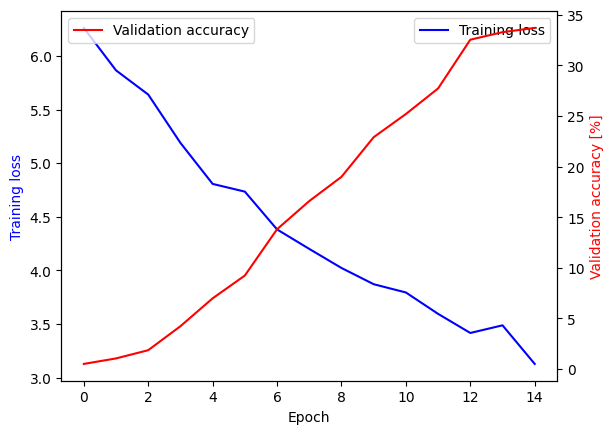

In [ ]:
import matplotlib.pyplot as plt

epoch_cutoff = 15

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(loss_history[:epoch_cutoff], color="blue", label="Training loss")
ax1.set_ylabel("Training loss", color="blue")

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data on the secondary y-axis
ax2.plot(accuracy_history[:epoch_cutoff], color="red", label="Validation accuracy")
ax2.set_ylabel("Validation accuracy [%]", color="red")

# Add legend
ax1.legend(loc="best")
ax2.legend(loc="best")
ax1.set_xlabel("Epoch")
# Show plot
plt.show()